<a href="https://colab.research.google.com/github/VinayNooji/FourthBrain/blob/main/3_3_Anomaly_Detection_with_PyOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection with the PyOD (Python Outlier Detector) Package

## Adapted from this Towards Data Science [blog post](https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9). For more details, read the [PyOD Documentation](https://pyod.readthedocs.io/en/latest/pyod.html) or check out the associated [GitHub repo](https://github.com/yzhao062/pyod).

### Set up the exercise

/usr/local/lib/python3.7/dist-packages/pyod/utils/data.py:189: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


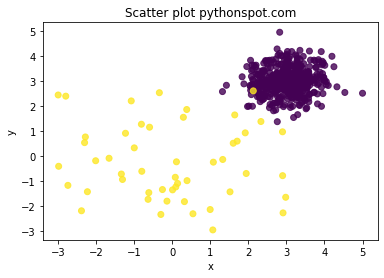

In [120]:
# Install and import the necessary modules
!pip install pyod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

# Set the parameters and generate the data
contamination = 0.1 # fraction of outliers
n_train = 500       # number of training points
n_test  = 500       # number of testing points
n_features = 2      # number of features
random_state = 18   # random state for reproducibility
X_train, y_train, X_test, y_test = generate_data(n_train=n_train, 
                                                 n_test=n_test, 
                                                 n_features=n_features, 
                                                 contamination=contamination,
                                                 random_state=random_state)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [121]:
print(f'For {n_train} training observations and {100*contamination} % contamination, we expect {int(n_train*contamination)} outliers')
print(f'For {n_test} test observations and {100*contamination} % contamination, we expect {int(n_test*contamination)} outliers')

For 500 training observations and 10.0 % contamination, we expect 50 outliers
For 500 test observations and 10.0 % contamination, we expect 50 outliers


### Let's see if we can find these outliers consistently

### PyOD provides many classification models which you could otherwise find in scikit-learn. However, PyOD's models allow the user to see intermediate scores which indicate the model's confidence in a given point being an outlier. Moreover, the user can then use the trained model to generate these outlier scores on test data.

### Let's see this in action with PyOD's k-NN model, which by default has `n_neighbors=5` for k

### Exercise: Train PyOD's default k-NN classifier and make predictions with it

### IMPORTANT NOTE: All of the models which we'll employ in this exercise are unsupervised! While we did generate ground truth labels along with features, we'll only use them for visualization purposes and not for training the models!

In [122]:
# -*- coding: utf-8 -*-
"""Example of combining multiple base outlier scores. Four combination
frameworks are demonstrated:
1. Average: take the average of all base detectors
2. maximization : take the maximum score across all detectors as the score
3. Average of Maximum (AOM)
4. Maximum of Average (MOA)
"""
# Author: Yue Zhao <zhaoy@cmu.edu>
# License: BSD 2 clause

#!pip install pyod
#!pip install --upgrade pyod # make sure the latest version is installed!
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
#from pyod.models.combination import aom, moa, average, maximization, median
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

if __name__ == "__main__":

    # Define data file and read X and y
    # Generate some data if the source data is missing
    mat_file = 'cardio.mat'
    try:
        mat = loadmat(os.path.join('data', mat_file))

    except TypeError:
        print('{data_file} does not exist. Use generated data'.format(
            data_file=mat_file))
        X, y = generate_data(train_only=True)  # load data
    except IOError:
        print('{data_file} does not exist. Use generated data'.format(
            data_file=mat_file))
        X, y = generate_data(train_only=True)  # load data
    else:
        X = mat['X']
        y = mat['y'].ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    # standardizing data for processing
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    n_clf = 3  # number of base detectors

    # Initialize 20 base detectors for combination
    k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,
              150, 160, 170, 180, 190, 200]

    train_scores = np.zeros([X_train.shape[0], n_clf])
    test_scores = np.zeros([X_test.shape[0], n_clf])

    print('Combining {n_clf} kNN detectors'.format(n_clf=n_clf))

    for i in range(n_clf):
        k = k_list[i]

        clf = KNN(n_neighbors=k, method='largest')
        clf.fit(X_train_norm)

        train_scores[:, i] = clf.decision_scores_
        test_scores[:, i] = clf.decision_function(X_test_norm)
        print(f'Shape {train_scores.shape}, i = {i}, k = {k}, values = {train_scores[:5,]}')
    # Decision scores have to be normalized before combination
    train_scores_norm, test_scores_norm = standardizer(train_scores,
                                                       test_scores)
    """
    # Combination by average
    y_by_average = average(test_scores_norm)
    evaluate_print('Combination by Average', y_test, y_by_average)

    # Combination by max
    y_by_maximization = maximization(test_scores_norm)
    evaluate_print('Combination by Maximization', y_test, y_by_maximization)

    # Combination by max
    y_by_maximization = median(test_scores_norm)
    evaluate_print('Combination by Median', y_test, y_by_maximization)

    # Combination by aom
    y_by_aom = aom(test_scores_norm, n_buckets=5)
    evaluate_print('Combination by AOM', y_test, y_by_aom)

    # Combination by moa
    y_by_moa = moa(test_scores_norm, n_buckets=5)
    evaluate_print('Combination by MOA', y_test, y_by_moa)
    """

cardio.mat does not exist. Use generated data
Combining 3 kNN detectors
Shape (600, 3), i = 0, k = 10, values = [[0.96810705 0.         0.        ]
 [0.11887539 0.         0.        ]
 [0.15697103 0.         0.        ]
 [0.15862142 0.         0.        ]
 [0.24579484 0.         0.        ]]
Shape (600, 3), i = 1, k = 20, values = [[0.96810705 1.15234262 0.        ]
 [0.11887539 0.22893302 0.        ]
 [0.15697103 0.21332634 0.        ]
 [0.15862142 0.21047899 0.        ]
 [0.24579484 0.3964664  0.        ]]
Shape (600, 3), i = 2, k = 30, values = [[0.96810705 1.15234262 1.3991339 ]
 [0.11887539 0.22893302 0.31142147]
 [0.15697103 0.21332634 0.26067612]
 [0.15862142 0.21047899 0.27892435]
 [0.24579484 0.3964664  0.47599291]]


In [123]:
# train kNN detector
from pyod.models.knn import KNN
from pyod.utils.utility import standardizer

def get_knn_scores_and_predictions(X_train, X_test, n_neighbors=5):
    ### START CODE HERE ###
    # Initialize the model
    clf = KNN(n_neighbors=n_neighbors)
    # Train the model
    clf.fit(X_train)
    #print(X_train[:10,])
    # Get the training data's outlier/decision scores with the decision_scores_ attribute
    y_train_scores = np.zeros((X_train.shape[0], 1))
    print(y_train_scores.shape)
    y_train_scores[:,0] = clf.decision_scores_
    # Generate the anomaly scores for the test data using the decision_function() method 
    y_test_scores = np.zeros((X_test.shape[0], 1))
    y_test_scores[:,0] = clf.decision_function(X_test)
    print(y_train_scores.shape)
    print(y_test_scores.shape)
    # Convert the outlier scores to 2D column arrays, then standardize them so they have 
    # a mean of 0 and standard deviation of 1
    y_train_scores_norm, y_test_scores_norm = standardizer(y_train_scores, y_test_scores)
    # Apply the model to the test data to get predictions
    y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
    ### END CODE HERE ###
    return y_train_scores_norm, y_test_scores_norm, y_test_pred

# Call the function with the default KNN
y_train_scores_norm, y_test_scores_norm, y_test_pred = get_knn_scores_and_predictions(X_train, X_test)
#get_knn_scores_and_predictions(X_train, X_test)

(600, 1)
(600, 1)
(400, 1)


### Count how many test data points are "normal" (inliers) and outliers

In [124]:
# We have a binary classification problem ("normal" points labeled 0 and outliers labeled 1)
# Let's see how many points are predicted to belong to each class
unique, counts = np.unique(y_test_pred, return_counts=True)
for label, count in dict(zip(unique, counts)).items():
    print(f'{count} points in the test data are predicted to belong to class {label}')

363 points in the test data are predicted to belong to class 0
37 points in the test data are predicted to belong to class 1


### Visualize the distribution of the standardized test data outlier scores

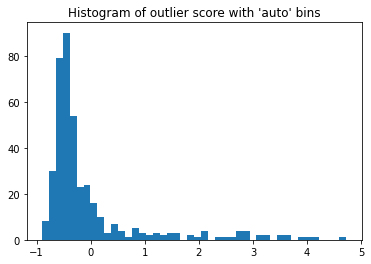

In [125]:
plt.hist(y_test_scores_norm, bins='auto') 
plt.title("Histogram of outlier score with 'auto' bins")
plt.show()

### It seems reasonable to assume that points with outlier scores below a certain threshold are assigned to Class 0 (the normal, inlier class), and those with scores above are assigned to Class 1 (the anomalous, outlier class). Where is that threshold, though? From glancing at the plot above, 0 appears to be a good threshold score. 

### Exercise: Assign test data points to inlier and outlier clusters based on the side of the threshold on which their outlier scores fall. Print the number of points assigned to each cluster and the mean value of each feature within each cluster.

In [126]:
s = pd.Series(range(5))
a = np.array(range(10, 15))
print(a)
s['test'] = a
#s.where(s['test'] > 10)

[10 11 12 13 14]


In [127]:
def clustering(X_test, y_test_scores_norm, threshold=0):
    ### START CODE HERE ###
    # Create a new DataFrame from the test features
    df_test = pd.DataFrame(data=X_test)
    # Make a new column containing each point's outlier score
    df_test['score'] = y_test_scores_norm
    # Assign each point to a cluster based on the side of the threshold
    # on which its outlier score falls
    df_test['cluster'] = np.where(df_test['score'] < threshold, 0, 1)
    #df_test['cluster'] = df_test.where(df_test['score'] > threshold, 0)
    #df_test['cluster'] = df_test.mask(df_test['score'][:] > threshold, 1)
    # Print the number of points assigned to each cluster
    print('Class counts:')
    print(df_test['cluster'].value_counts())
    # Display the mean values of each feature within each cluster
    print()
    print('Mean value of each feature within each cluster:')
    print(df_test.groupby(['cluster']).mean())

    inlier_mean = df_test.loc[df_test['cluster'] == 0,'score'].mean()
    outlier_mean = df_test.loc[df_test['cluster'] == 1,'score'].mean()
    print(f'Mean of inliers {inlier_mean}, Mean of outliers {outlier_mean}')
    ### END CODE HERE ###
    return df_test

# Call the function
#print(y_test_scores_norm)
#df_test = pd.DataFrame(data=X_test)
#df_test['score'] = y_test_scores_norm
#print(df_test.shape)
#print(df_test['score'][:])
#df_test['cluster'] = df_test.where(df_test['score'][:] > 0, 1)
#df_test['cluster'] = np.where(df_test['score'] < 0, 0, 1)
#print(df_test['cluster'][:])
#print(df_test['cluster'].value_counts())
#print(df_test.groupby('cluster').mean())
#inlier_mean = df_test.loc[df_test['cluster'] == 0,'score'].mean()
#outlier_mean = df_test.loc[df_test['cluster'] == 1,'score'].mean()
#print(f'Mean of inliers {inlier_mean}, Mean of outliers {outlier_mean}')
df_test = clustering(X_test, y_test_scores_norm, threshold=0)

Class counts:
0    308
1     92
Name: cluster, dtype: int64

Mean value of each feature within each cluster:
                0         1     score
cluster                              
0        1.995612  2.063206 -0.450099
1        1.223959  1.045202  1.332266
Mean of inliers -0.45009886656325043, Mean of outliers 1.3322658658725353


### Keep in mind that the horizontal labels in the figure immediately above correspond to feature names, not cluster numbers. The inliers and outliers are thus quite well separated.

### Inspect visually how our model performed

In [128]:
def get_plots(X_test, y_test, y_test_pred, df_test):
    plt.tight_layout()

    plt.subplots(1, 3, figsize = (18, 6))

    plt.subplot(1,3,1)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.8)
    plt.title('Inliers vs. Outliers: Ground Truth')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1,3,2)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test_pred, alpha=0.8)
    plt.title('Inliers vs. Outliers: Automatic Predictions')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1,3,3)
    plt.scatter(df_test[0], df_test[1], c=df_test['cluster'], alpha=0.8)
    plt.title('Inliers vs. Outliers: Predictions by Threshold')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    # Dummy return
    return None

<Figure size 432x288 with 0 Axes>

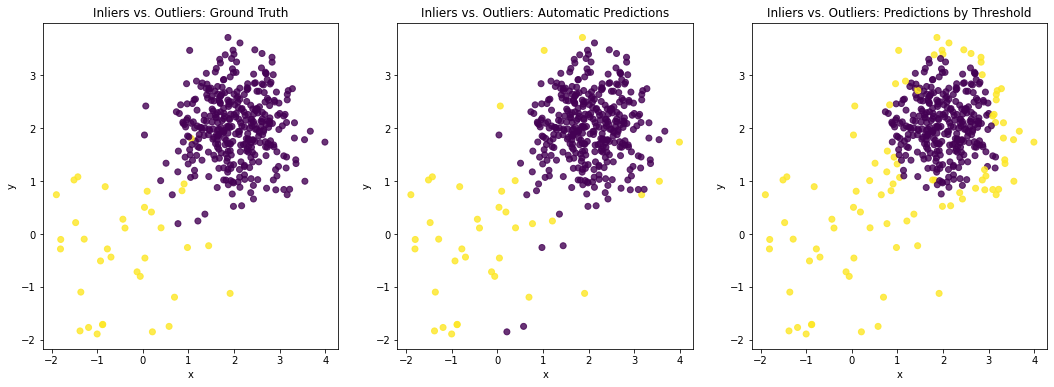

In [129]:
get_plots(X_test, y_test, y_test_pred, df_test)

### Exercise: Combine the previous exercises and visualizations into a single overarching function. Then use that function to run k-NN anomaly detection with k = 1 and k = 9.

In [130]:
def knn_anomaly_detection(X_train, y_train, X_test, y_test, n_neighbors=5, threshold=0): 
    ### START CODE HERE ###
    # Get scores and predictions
    print(f'n_neighbors {n_neighbors}')
    y_train_scores_norm, y_test_scores_norm, y_test_pred = get_knn_scores_and_predictions(X_train, X_test, n_neighbors=n_neighbors)
    # Count the number of points in the test data predicted to belong to each class
    unique, counts = np.unique(y_test_pred, return_counts=True)
    for label, count in dict(zip(unique, counts)).items():
        print(f'{count} points in the test data are predicted to belong to class {label}')
    # Visualize the distribution of outlier scores in the test data
    plt.hist(y_test_scores_norm, bins='auto') 
    plt.title("Histogram of outlier score with 'auto' bins")
    plt.show()
    # Clustering by threshold
    df_test = clustering(X_test, y_test_scores_norm, threshold)
    # Get plots
    get_plots(X_test, y_test, y_test_pred, df_test)
    ### END CODE HERE ###
    # Dummy return
    return None

n_neighbors 1
(600, 1)
(600, 1)
(400, 1)
356 points in the test data are predicted to belong to class 0
44 points in the test data are predicted to belong to class 1


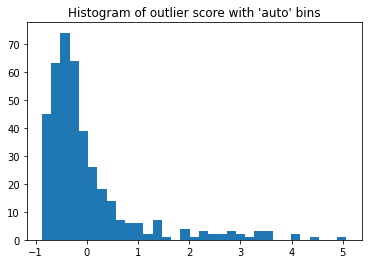

Class counts:
0    282
1    118
Name: cluster, dtype: int64

Mean value of each feature within each cluster:
                0         1     score
cluster                              
0        2.018666  2.006527 -0.432637
1        1.338888  1.404959  1.074070
Mean of inliers -0.43263681078692273, Mean of outliers 1.074070158618829


<Figure size 432x288 with 0 Axes>

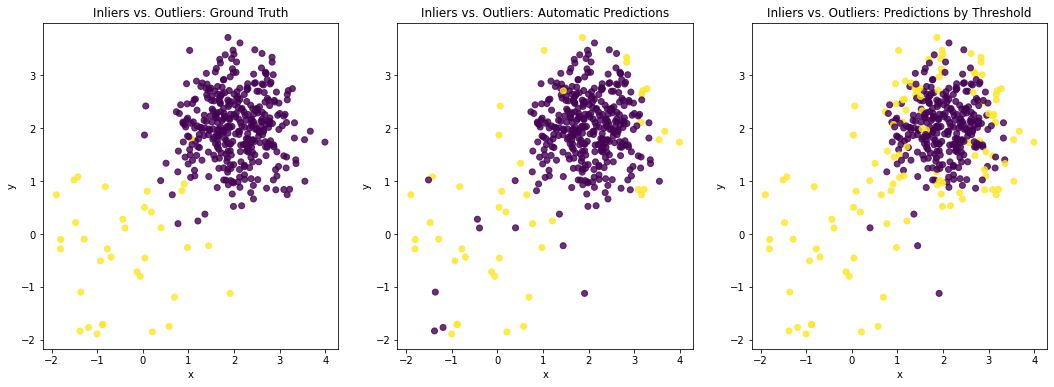

In [131]:
knn_anomaly_detection(X_train, y_train, X_test, y_test, n_neighbors=1, threshold=0)

n_neighbors 9
(600, 1)
(600, 1)
(400, 1)
366 points in the test data are predicted to belong to class 0
34 points in the test data are predicted to belong to class 1


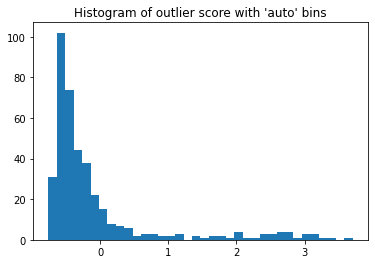

Class counts:
0    315
1     85
Name: cluster, dtype: int64

Mean value of each feature within each cluster:
                0         1     score
cluster                              
0        1.992892  2.049929 -0.438112
1        1.170493  1.010569  1.333108
Mean of inliers -0.43811188336043566, Mean of outliers 1.3331082683467887


<Figure size 432x288 with 0 Axes>

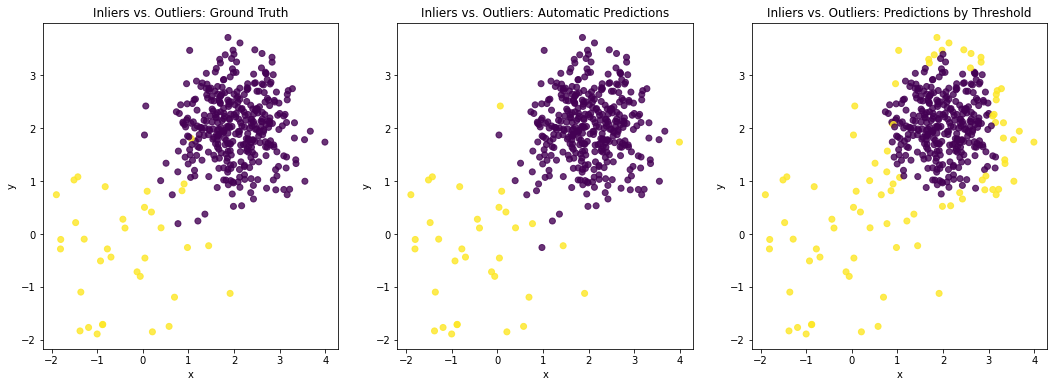

In [132]:
knn_anomaly_detection(X_train, y_train, X_test, y_test, n_neighbors=9, threshold=0)

### Excercise: Set up a function to get PCA scores and predictions

In [133]:
from pyod.models.pca import PCA

def get_pca_scores_and_predictions(X_train, X_test, n_components=2):
    ### START CODE HERE ###
    # Initialize the model
    print(f'n_components = {n_components}')
    clf = PCA(n_components=n_components)
    # Train the model
    clf.fit(X_train)
    # Get the training data's outlier/decision scores with the decision_scores_ attribute
    y_train_scores = np.zeros((X_train.shape[0], 1))
    y_train_scores[:,0] = clf.decision_scores_
    # Generate the anomaly score using the decision_function() method
    y_test_scores = np.zeros((X_test.shape[0], 1))
    y_test_scores[:,0] = clf.decision_function(X_test)
    # Convert the outlier scores to 2D column arrays, then standardize them
    y_train_scores_norm, y_test_scores_norm = standardizer(y_train_scores, y_test_scores)
    # Apply the model to the test data to get predictions
    y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
    ### END CODE HERE ###
    return y_train_scores_norm, y_test_scores_norm, y_test_pred


### Exercise: Implement an overarching PCA anomaly detection function

In [134]:
def pca_anomaly_detection(X_train, y_train, X_test, y_test, n_components=2, threshold=0):
    ### START CODE HERE ###
    # Get scores and predictions
    y_train_scores_norm, y_test_scores_norm, y_test_pred = get_pca_scores_and_predictions(X_train, X_test, n_components=n_components)
    # Count the number of points in the test data predicted to belong to each class
    unique, counts = np.unique(y_test_pred, return_counts=True)
    for label, count in dict(zip(unique, counts)).items():
        print(f'{count} points in the test data are predicted to belong to class {label}')
    # Visualize the distribution of outlier scores in the test data
    plt.hist(y_test_scores_norm, bins='auto') 
    plt.title("Histogram of outlier score with 'auto' bins")
    plt.show()
    # Clustering by threshold
    df_test = clustering(X_test, y_test_scores_norm, threshold)
    # Get plots
    get_plots(X_test, y_test, y_test_pred, df_test)
    ### END CODE HERE ###
    # Dummy return
    return None

### Run the PCA anomaly detection function with 2 components and the default outlier score threshold

n_components = 2
361 points in the test data are predicted to belong to class 0
39 points in the test data are predicted to belong to class 1


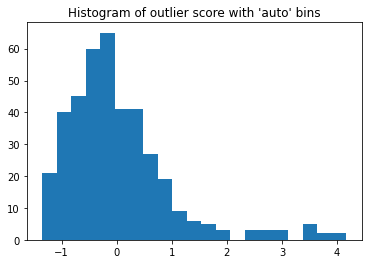

Class counts:
0    235
1    165
Name: cluster, dtype: int64

Mean value of each feature within each cluster:
                0         1     score
cluster                              
0        2.043296  1.698172 -0.560125
1        1.497443  2.015488  0.851059
Mean of inliers -0.5601251753781515, Mean of outliers 0.8510590173339905


<Figure size 432x288 with 0 Axes>

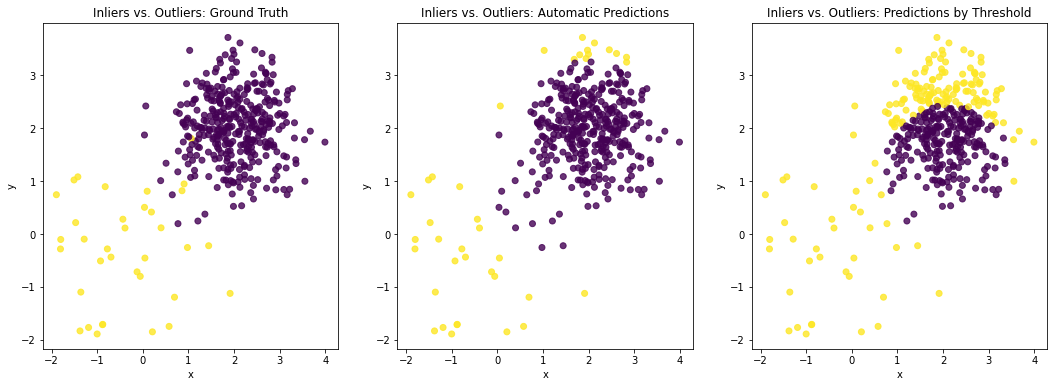

In [135]:
pca_anomaly_detection(X_train, y_train, X_test, y_test, n_components=2, threshold=0)

### Hmm, PCA didn't distribute the anomaly scores nearly as tightly as k-NN did. Moreover, the right tail of the anomaly scores' distribution appears to begin around 1. Let's rerun our PCA anomaly detection function with 1 as our threshold instead.

n_components = 2
361 points in the test data are predicted to belong to class 0
39 points in the test data are predicted to belong to class 1


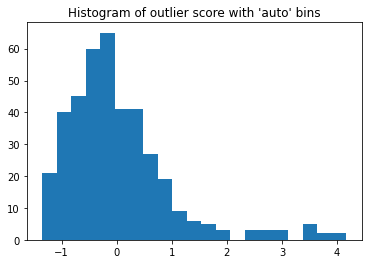

Class counts:
0    358
1     42
Name: cluster, dtype: int64

Mean value of each feature within each cluster:
                0         1     score
cluster                              
0        2.002537  1.941228 -0.229752
1        0.246294  0.873006  2.167776
Mean of inliers -0.2297522007669788, Mean of outliers 2.16777641716241


<Figure size 432x288 with 0 Axes>

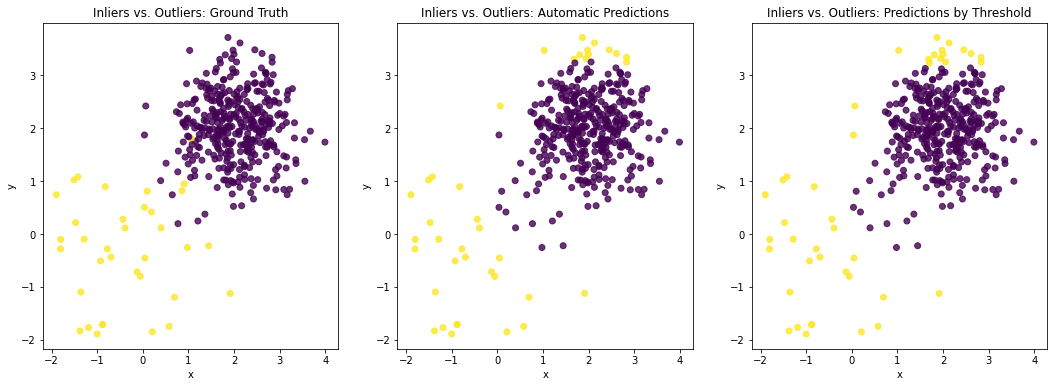

In [136]:
pca_anomaly_detection(X_train, y_train, X_test, y_test, n_components=2, threshold=1)